In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# %matplotlib inline
plt.ion()   # interactive mode

# Load data 

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = 'data/hymenoptera_data'

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [8]:
class_names = image_datasets['train'].classes

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images 

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [12]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

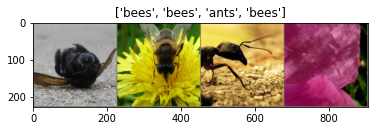

In [13]:
imshow(out, title=[class_names[x] for x in classes])

# Training the model 

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions 

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet 

In [16]:
model_ft = models.resnet18(pretrained=True)

In [17]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # nn.Linear(num_ftrs, len(class_names))

In [18]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate 

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


c:\users\aleks\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5299 Acc: 0.7418
val Loss: 0.1968 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4334 Acc: 0.8074
val Loss: 0.2967 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5374 Acc: 0.7664
val Loss: 0.1813 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4792 Acc: 0.8033
val Loss: 0.2670 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4264 Acc: 0.8115
val Loss: 0.2194 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4721 Acc: 0.7992
val Loss: 0.2960 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5921 Acc: 0.7828
val Loss: 0.2909 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.2818 Acc: 0.8811
val Loss: 0.2158 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3403 Acc: 0.8730
val Loss: 0.2196 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2654 Acc: 0.8852
val Loss: 0.2443 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.8443
val Loss: 0.2049 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2981 Acc: 0.8852
val Loss: 0.2013 Acc: 0.9346

Epoch 12/24
----------
t

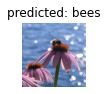

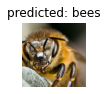

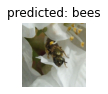

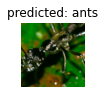

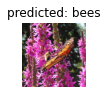

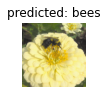

In [20]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor 

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [22]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [23]:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate 

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6039 Acc: 0.7008
val Loss: 0.3636 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4519 Acc: 0.7787
val Loss: 0.1842 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4351 Acc: 0.7869
val Loss: 0.2898 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4549 Acc: 0.7869
val Loss: 0.4487 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.6865 Acc: 0.7049
val Loss: 0.1965 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4362 Acc: 0.7992
val Loss: 0.2622 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4854 Acc: 0.7828
val Loss: 0.1831 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3921 Acc: 0.8238
val Loss: 0.1903 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3114 Acc: 0.8607
val Loss: 0.1786 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3453 Acc: 0.8689
val Loss: 0.1913 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2494 Acc: 0.8934
val Loss: 0.1927 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3556 Acc: 0.8443
val Loss: 0.1946 Acc: 0.9412

Ep

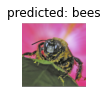

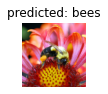

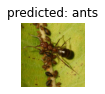

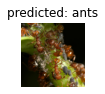

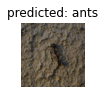

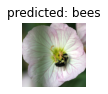

In [25]:
visualize_model(model_conv)
plt.ioff()
plt.show()